# Evaluation and plotting for different experiments

- Write throughput (fio vs dd, isilon vs netapp)
- Containerized fio vs non-containerized fio

In [1]:
from __future__ import annotations
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import scipy.stats as st
from datetime import datetime, timedelta

In [2]:
METRIC = {
    "throughput_write": "write_bw_mean_in_MiB",
    "iops_write": "write_iops_mean",
    "latency_write": "write_lat_mean_in_ms",
    "throughput_read": "read_bw_mean_in_MiB",
    "iops_read": "read_iops_mean",
    "latency_read": "read_lat_mean_in_ms",
}

def load_data(filename: Path | str, metric: str, suffix: str="", x_labels=None) -> pd.DataFrame:
    """Load data either from file or from multiple files placed in a directory"""
    path = Path(filename)
    if path.is_file():
        data = load_json(path)
    elif path.is_dir():
        data = load_dir(path, suffix)
    else:
        data = load_json(str(path)+suffix)
    return extract_results(data, metric, x_labels)

def load_json(filename: Path | str) -> dict:
    """Load file as json"""
    file = Path(filename)
    assert file.is_file(), f"{file} is not a file"
    return json.loads(file.read_text())

def load_dir(path: Path, suffix: str) -> dict:
    """Combine results of multiple files in directory. Specify files by suffix"""
    res = {"results":{}}

    for file in path.glob(f"*{suffix}"):
        data = load_json(file)

        for key, value in data["results"].items():
            if key not in res["results"]:
                res["results"][key] = []
            res["results"][key].extend(value)

    return res

def extract_results(data, metric, x_labels=None):
    x_labels = x_labels if x_labels else list(data["results"].keys())
    pd_data = []
    for label in x_labels:
        results = data["results"][label]
        values = [float(r[metric]) for r in results]
        values = [v for v in values if v > 0]
        mean = np.mean(values)
        conf = confidence_interval(values)
        std = np.std(values)
        num = len(values)
        pd_data.append([mean, std, num])


    df = pd.DataFrame(data=pd_data, index=x_labels, columns=["mean", "std", "num"])
    df.rename(index={"1024": 1, "2048": 2, "4096": 4, "8192": 8, "16384": 16}, inplace=True)
    df.rename(index={"256M": 0.25, "1G": 1, "2G": 2, "4G": 4, "8G": 8, "16G": 16}, inplace=True)
    df.rename(index={"1k": 1, "4k": 4, "16k": 16, "64k": 64, "256k": 256, "1024k": 1024, "4096k": 4096, "16384k": 16384}, inplace=True)
    df.rename(index={"1": 1, "2": 2, "4": 4, "8": 8, "16": 16, "32": 32}, inplace=True)
    df.rename(index={"10": 10, "20": 20, "60": 60, "120": 120, "300": 300}, inplace=True)

    return df

def confidence_interval(values):
    confidence = 0.95
    dof = len(values)-1
    m = np.mean(values)
    sem = st.sem(values)
    interval = st.t.interval(alpha=confidence, df=dof, loc=m, scale=sem)
    if np.isnan(interval[0]) or np.isnan(interval[1]):
        return m * 10**-6
    return (interval[1]-interval[0])/2
    
def plot(filename, metric="write_bw_mean_in_mb"):
    data = load_json(filename)
    df = extract_results(data, metric=metric)
    print(df)
    ax = df["mean"].plot(kind='bar', rot=0, xlabel='Date', ylabel='Value', title='My Plot', figsize=(6, 4), yerr=df["conf"])
    plt.show()

def tex_table(lst):
    for item in lst:
        print(*item, sep=" & ", end="\\\\\n")

# Experiment: Parameter-evaluation: dd

<IPython.core.display.Javascript object>


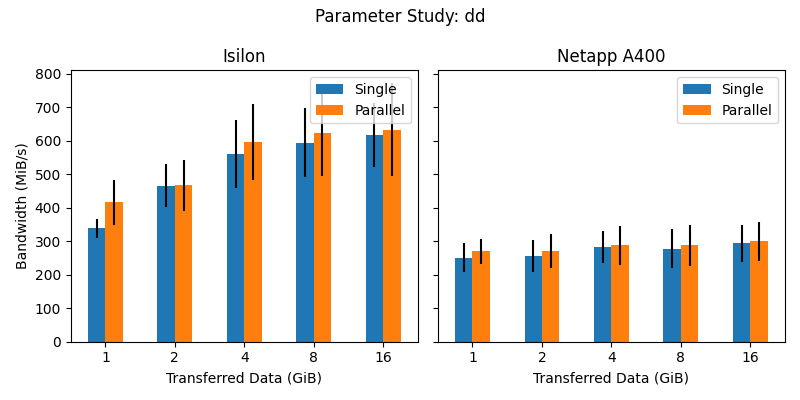

In [3]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_dd_")
folder = Path("./results/param_study_dd")

## Plot code
path = file_prefix if file_prefix else folder

df_isilon = pd.concat({
    "Single": load_data(path, metric="bw_in_MiB", suffix="isilon_a.json"),
    "Parallel": load_data(path, metric="bw_in_MiB", suffix="isilon_b.json"),
})

df_netapp = pd.concat({
    "Single": load_data(path, metric="bw_in_MiB", suffix="netapp_a.json"),
    "Parallel": load_data(path, metric="bw_in_MiB", suffix="netapp_b.json"),
})

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Parameter Study: dd')

df_isilon["mean"].unstack(level=0)[["Single","Parallel"]].plot(
    ax=ax1,
    kind='bar', rot=0,
    xlabel='Transferred Data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"Isilon",
    figsize=(8, 4),
    yerr=df_isilon["std"].unstack(level=0)[["Single","Parallel"]]
)

df_netapp["mean"].unstack(level=0)[["Single","Parallel"]].plot(
    ax=ax2,
    kind='bar', rot=0,
    xlabel='Transferred Data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"Netapp A400",
    figsize=(8, 4),
    yerr=df_netapp["std"].unstack(level=0)[["Single","Parallel"]],
)

plt.tight_layout()
plt.savefig("paramstudy_dd.png",bbox_inches='tight')
plt.show()


# Experiment: Parameter-evaluation: Fio

<IPython.core.display.Javascript object>


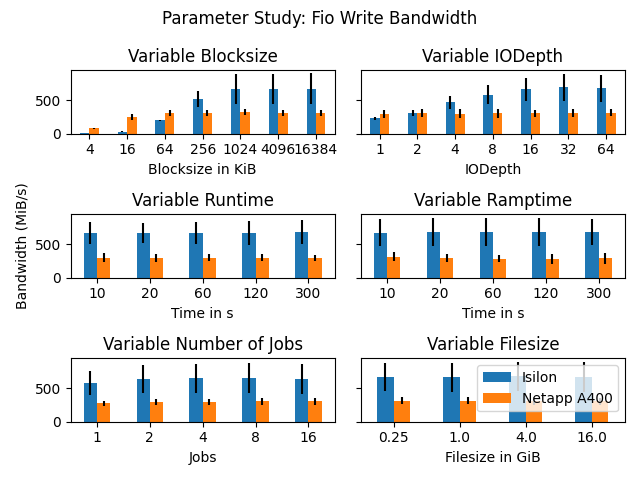

In [4]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-05-17T21:18:41_throughput_write_")
folder = Path("./results/param_study_fio_throughput")

## Plot code
path = file_prefix if file_prefix else folder


post_i = "_isilon.json"
post_n = "_netapp.json"
metric = METRIC["throughput_write"]

df_1 = pd.concat({
    "Isilon": load_data(path, suffix="blocksize"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="blocksize"+post_n, metric=metric),
})
df_2 = pd.concat({
    "Isilon": load_data(path, suffix="iodepth"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="iodepth"+post_n, metric=metric),
})
df_3 = pd.concat({
    "Isilon": load_data(path, suffix="runtime"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="runtime"+post_n, metric=metric),
})
df_4 = pd.concat({
    "Isilon": load_data(path, suffix="ramptime"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="ramptime"+post_n, metric=metric),
})
df_5 = pd.concat({
    "Isilon": load_data(path, suffix="numjobs"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="numjobs"+post_n, metric=metric),
})
df_6 = pd.concat({
    "Isilon": load_data(path, suffix="filesize"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="filesize"+post_n, metric=metric),
})

fig, axis = plt.subplots(3, 2, sharey=True)
fig.suptitle('Parameter Study: Fio Write Bandwidth')

    
df_1["mean"].unstack(level=0).plot(
    ax=axis[0][0],
    kind='bar', rot=0,
    xlabel='Blocksize in KiB',
    title='Variable Blocksize',
    yerr=df_1["std"].unstack(level=0)
)
df_2["mean"].unstack(level=0).plot(
    ax=axis[0][1],
    kind='bar', rot=0,
    xlabel='IODepth',
    title='Variable IODepth',
    yerr=df_2["std"].unstack(level=0)
)

df_3["mean"].unstack(level=0).plot(
    ax=axis[1][0],
    kind='bar', rot=0,
    xlabel='Time in s',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Runtime',
    yerr=df_3["std"].unstack(level=0)
)

df_4["mean"].unstack(level=0).plot(
    ax=axis[1][1],
    kind='bar', rot=0,
    xlabel='Time in s',
    title='Variable Ramptime',
    yerr=df_4["std"].unstack(level=0)
)
df_5["mean"].unstack(level=0).plot(
    ax=axis[2][0],
    kind='bar', rot=0,
    xlabel='Jobs',
    title='Variable Number of Jobs',
    yerr=df_5["std"].unstack(level=0)
)
df_6["mean"].unstack(level=0).plot(
    ax=axis[2][1],
    kind='bar', rot=0,
    xlabel='Filesize in GiB',
    title='Variable Filesize',
    yerr=df_6["std"].unstack(level=0)
)
for i,j in [(0,0),(0,1),(1,0),(1,1),(2,0)]:
    axis[i][j].get_legend().remove()
    
plt.tight_layout()
plt.savefig("paramstudy_fio_throughput.png",bbox_inches='tight')
plt.show()


<IPython.core.display.Javascript object>


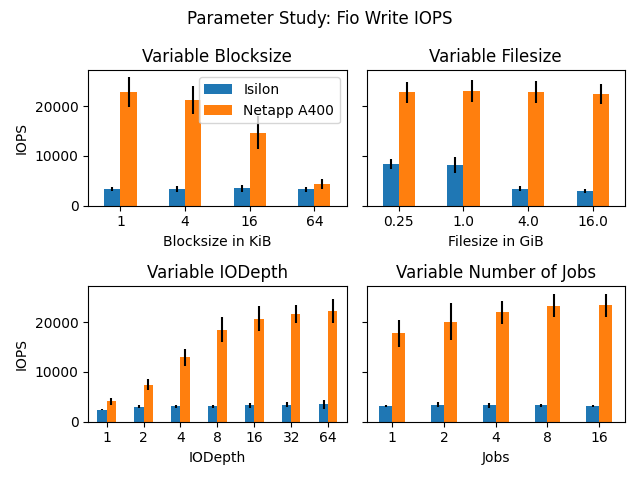

In [5]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T22:22:50_iops_write_")
folder = Path("./results/param_study_fio_iops")

## Plot code
path = file_prefix if file_prefix else folder


post_i = "_isilon.json"
post_n = "_netapp.json"
metric = METRIC["iops_write"]

df_1 = pd.concat({
    "Isilon": load_data(path, suffix="blocksize"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="blocksize"+post_n, metric=metric),
})
df_2 = pd.concat({
    "Isilon": load_data(path, suffix="filesize"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="filesize"+post_n, metric=metric),
})
df_3 = pd.concat({
    "Isilon": load_data(path, suffix="iodepth"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="iodepth"+post_n, metric=metric),
})
df_4 = pd.concat({
    "Isilon": load_data(path, suffix="numjobs"+post_i, metric=metric),
    "Netapp A400": load_data(path, suffix="numjobs"+post_n, metric=metric),
})

fig, axis = plt.subplots(2, 2, sharey=True)
fig.suptitle('Parameter Study: Fio Write IOPS')

    
df_1["mean"].unstack(level=0).plot(
    ax=axis[0][0],
    kind='bar', rot=0,
    xlabel='Blocksize in KiB',
    ylabel='IOPS',
    title='Variable Blocksize',
    yerr=df_1["std"].unstack(level=0)
)
df_2["mean"].unstack(level=0).plot(
    ax=axis[0][1],
    kind='bar', rot=0,
    xlabel='Filesize in GiB',
    title='Variable Filesize',
    yerr=df_2["std"].unstack(level=0)
)

df_3["mean"].unstack(level=0).plot(
    ax=axis[1][0],
    kind='bar', rot=0,
    xlabel='IODepth',
    ylabel='IOPS',
    title='Variable IODepth',
    yerr=df_3["std"].unstack(level=0)
)

df_4["mean"].unstack(level=0).plot(
    ax=axis[1][1],
    kind='bar', rot=0,
    xlabel='Jobs',
    title='Variable Number of Jobs',
    yerr=df_4["std"].unstack(level=0)
)

for i,j in [(0,1),(1,0),(1,1)]:
    axis[i][j].get_legend().remove()
    
plt.tight_layout()
plt.savefig("paramstudy_fio_iops.png",bbox_inches='tight')
plt.show()


# Experiment: Parameter-evaluation: s3-benchmark

<IPython.core.display.Javascript object>


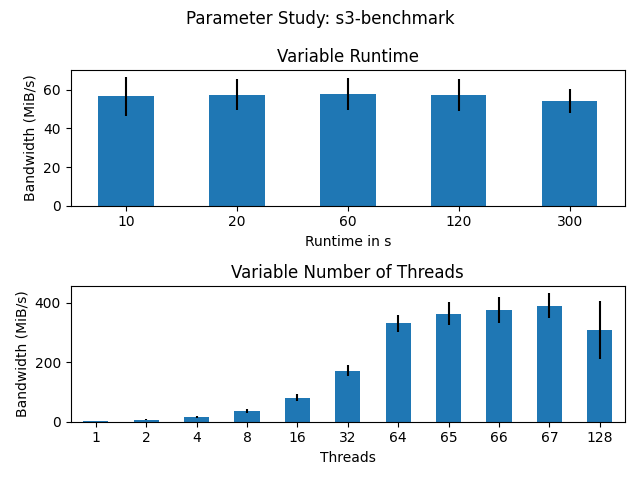

In [6]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-17T20:00:04_parameval_s3benchmark_")
folder = Path("./results/param_study_s3benchmark")

## Plot code
path = file_prefix if file_prefix else folder

metric = "put_bw_in_mibi"
df_1 = load_data(path, suffix="runtime.json", metric=metric)
df_2 = load_data(path, suffix="threads.json", metric=metric)

fig, axis = plt.subplots(2, 1)
fig.suptitle('Parameter Study: s3-benchmark')

    
df_1["mean"].plot(
    ax=axis[0],
    kind='bar', rot=0,
    xlabel='Runtime in s',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Runtime',
    yerr=df_1["std"]
)
df_2["mean"].plot(
    ax=axis[1],
    kind='bar', rot=0,
    xlabel='Threads',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Number of Threads',
    yerr=df_2["std"]
)

plt.tight_layout()
plt.savefig("paramstudy_s3benchmark.png",bbox_inches='tight')
plt.show()


# Experiment: Parameter-evaluation: Warp

<IPython.core.display.Javascript object>


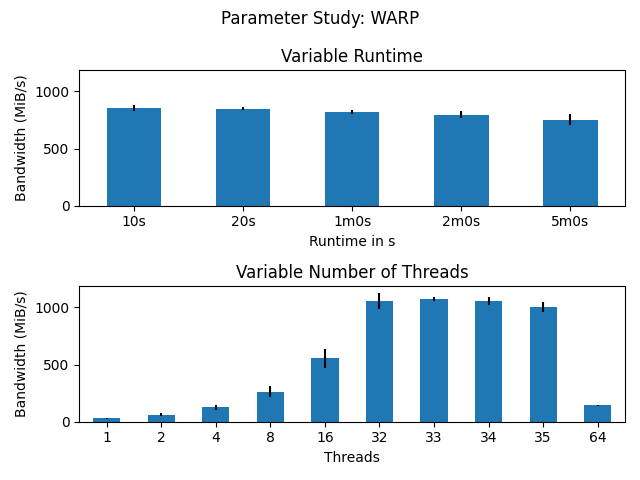

In [7]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-13T11:04:51_parameval_warp_")
folder = Path("./results/param_study_warp")

## Plot code
path = file_prefix if file_prefix else folder

metric = "put_bw_in_MiB"
df_1 = load_data(path, suffix="runtime.json", metric=metric)
df_2 = load_data(path, suffix="concurrent.json", metric=metric)

fig, axis = plt.subplots(2, 1, sharey=True)
fig.suptitle('Parameter Study: WARP')

    
df_1["mean"].plot(
    ax=axis[0],
    kind='bar', rot=0,
    xlabel='Runtime in s',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Runtime',
    yerr=df_1["std"]
)
df_2["mean"].plot(
    ax=axis[1],
    kind='bar', rot=0,
    xlabel='Threads',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Number of Threads',
    yerr=df_2["std"]
)

plt.tight_layout()
plt.savefig("paramstudy_warp.png",bbox_inches='tight')
plt.show()


# Experiment: Compare dd and fio

<IPython.core.display.Javascript object>


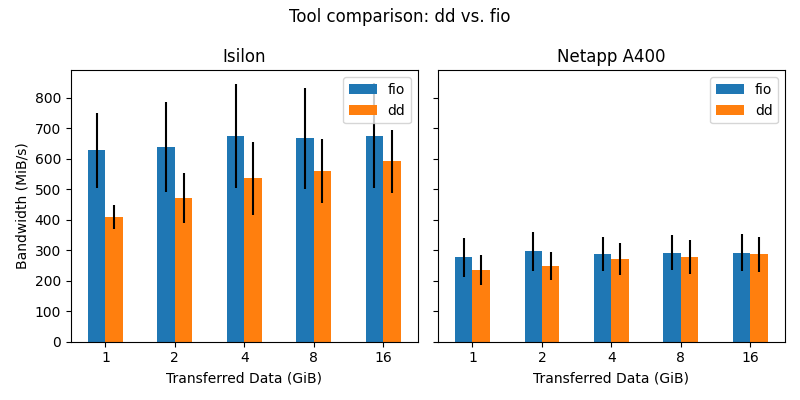

In [8]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_")
folder = Path("./results/compare_dd_vs_fio")

## Plot code
path = file_prefix if file_prefix else folder

df_isilon = pd.concat({
    "fio": load_data(path, metric="write_bw_mean_in_MiB", suffix="isilon_a.json"),
    "dd": load_data(path, metric="bw_in_MiB", suffix="isilon_b.json"),
})

df_netapp = pd.concat({
    "fio": load_data(path, metric="write_bw_mean_in_MiB", suffix="netapp_a.json"),
    "dd": load_data(path, metric="bw_in_MiB", suffix="netapp_b.json"),
})

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Tool comparison: dd vs. fio')

df_isilon["mean"].unstack(level=0).plot(
    ax=ax1,
    kind='bar', rot=0,
    xlabel='Transferred Data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"Isilon",
    figsize=(8, 4),
    yerr=df_isilon["std"].unstack(level=0)
)

df_netapp["mean"].unstack(level=0).plot(
    ax=ax2,
    kind='bar', rot=0,
    xlabel='Transferred Data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"Netapp A400",
    figsize=(8, 4),
    yerr=df_netapp["std"].unstack(level=0)
)

plt.tight_layout()
plt.savefig("dd_vs_fio.png",bbox_inches='tight')
plt.show()



# Experiment: Native vs Container

In [9]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-05-31T21:42:26_con_vs_nativ_")
folder = Path("./results/compare_native_vs_container")

## Plot code
path = file_prefix if file_prefix else folder

def load_df(benchmark):

    df = pd.concat([
        load_data(path, suffix=benchmark+"_con.json", metric=METRIC[benchmark]).rename(index={"con_vs_nativ_"+benchmark+"_con": "container"}),
        load_data(path, suffix=benchmark+"_nativ.json", metric=METRIC[benchmark]).rename(index={"con_vs_nativ_"+benchmark+"_nativ": "nativ"}),
    ])

    return df
df_1 = load_df("throughput_write")
df_2 = load_df("iops_write")
df_3 = load_df("latency_write")
df_4 = load_df("throughput_read")
df_5 = load_df("iops_read")
df_6 = load_df("latency_read")

def extract(df):
    return (
        df.loc['nativ'].at['mean'],
        df.loc['nativ'].at['std'],
        df.loc['container'].at['mean'],
        df.loc['container'].at['std'],
    )

## {1}{2}{3}{4}
# 1: b=troughput, i=iops, l=latency
# 2: w=write, r=read
# 3: n=nativ, c=container
# 4: m=mean, c=conf
 
bwnm, bwnc, bwcm, bwcc = extract(df_1)
brnm, brnc, brcm, brcc = extract(df_4)
iwnm, iwnc, iwcm, iwcc = extract(df_2)
irnm, irnc, ircm, ircc = extract(df_5)
lwnm, lwnc, lwcm, lwcc = extract(df_3)
lrnm, lrnc, lrcm, lrcc = extract(df_6)


tex_table([
    ["", "", "\multicolumn{3}{c}{Native}", "\multicolumn{3}{c}{Container}"],
    ["Bandwidth (MiB/s)", "write", f"{bwnm:.0f}", "$\pm$", f"{bwnc:.0f}", f"{bwcm:.0f}", "$\pm$", f"{bwcc:.0f}"],
    [""                 , "read" , f"{brnm:.0f}", "$\pm$", f"{brnc:.0f}", f"{brcm:.0f}", "$\pm$", f"{brcc:.0f}"],
    ["IOPS (ops/s)"     , "write", f"{iwnm:.0f}", "$\pm$", f"{iwnc:.0f}", f"{iwcm:.0f}", "$\pm$", f"{iwcc:.0f}"],
    [""                 , "read" , f"{irnm:.0f}", "$\pm$", f"{irnc:.0f}", f"{ircm:.0f}", "$\pm$", f"{ircc:.0f}"],
    ["Latency (ms)"     , "write", f"{lwnm:.2f}", "$\pm$", f"{lwnc:.3f}", f"{lwcm:.2f}", "$\pm$", f"{lwcc:.3f}"],
    [""                 , "read" , f"{lrnm:.2f}", "$\pm$", f"{lrnc:.3f}", f"{lrcm:.2f}", "$\pm$", f"{lrcc:.3f}"],
])

 &  & \multicolumn{3}{c}{Native} & \multicolumn{3}{c}{Container}\\
Bandwidth (MiB/s) & write & 669 & $\pm$ & 195 & 652 & $\pm$ & 182\\
 & read & 543 & $\pm$ & 161 & 542 & $\pm$ & 157\\
IOPS (ops/s) & write & 3652 & $\pm$ & 608 & 3796 & $\pm$ & 599\\
 & read & 22705 & $\pm$ & 1107 & 22624 & $\pm$ & 1196\\
Latency (ms) & write & 1.02 & $\pm$ & 0.059 & 0.99 & $\pm$ & 0.044\\
 & read & 0.55 & $\pm$ & 0.022 & 0.55 & $\pm$ & 0.020\\


# Experiment: Compare S3Benchmark vs Warp

# Experiment: Daytime evaluation

Netapp A400 & 217 & 539 & 383 & 4 & 55\\
 & 191 & 540 & 384 & 4 & 57\\
Isilon & 250 & 1036 & 791 & 13 & 172\\
 & 297 & 1034 & 785 & 14 & 172\\
Netapp StorageGRID & 428 & 1110 & 1053 & 6 & 78\\
 & 715 & 1110 & 1055 & 6 & 70\\


<IPython.core.display.Javascript object>


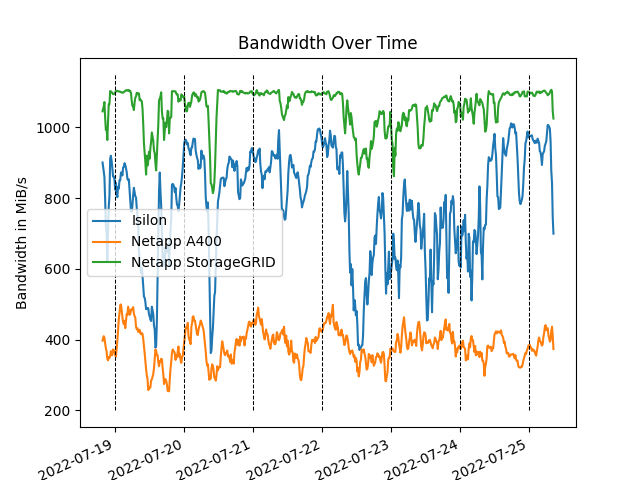

In [10]:
%matplotlib notebook

# Read in results
## Params
folder = Path("./results/daytime_eval")

## Plot code
res = {}


def _load():
    # res: dict[datetime, results]
    # results: dict[tuple[system, num], bw_in_MiB]
    for file in folder.iterdir():
        date_str, _, _, system, num = file.stem.split("_")
        date = datetime.fromisoformat(date_str) + timedelta(hours=2)
        file_content = json.loads(file.read_text())

        run_res = file_content["results"][f"daytime_evaluation_{system}_{num}"]
        if len(run_res) == 0:
            print("No result for:", date_str, system, num)
            continue
        if "put_bw_in_MiB" in run_res[0]:
            value = float(run_res[0]["put_bw_in_MiB"])
        else:
            value = run_res[0]["write_bw_mean_in_MiB"] 

        if date not in res:
            res[date] = {}

        key = (system, int(num))
        if key in res:
            print("Duplication for:", date, key)
        res[date][key] = value

    labels = sorted(k for k in res.keys())
    return labels, res

def generate_tex_table(labels, res):
    # Generate values for tex-table
    values_netapp_1 = []
    values_netapp_2 = []
    values_isilon_1 = []
    values_isilon_2 = []
    values_s3_1 = []
    values_s3_2 = []

    for key in labels:
        value = res[key]
        values_netapp_1.append(value.get(("netapp", 1), 0))
        values_netapp_2.append(value.get(("netapp", 2), 0))
        values_isilon_1.append(value.get(("isilon", 1), 0))
        values_isilon_2.append(value.get(("isilon", 2), 0))
        values_s3_1.append(value.get(("s3", 1), 0))
        values_s3_2.append(value.get(("s3", 2), 0))

    def extract_stats(values, label=""):
        min_, max_ = min(values), max(values)
        avg, conf = sum(values)/len(values), confidence_interval(values)
        std = np.std(values)
        print(f"{label} & {min_:.0f} & {max_:.0f} & {avg:.0f} & {conf:.0f} & {std:.0f}\\\\")

    extract_stats(values_netapp_1, "Netapp A400")
    extract_stats(values_netapp_2)
    extract_stats(values_isilon_1, "Isilon")
    extract_stats(values_isilon_2)
    extract_stats(values_s3_1, "Netapp StorageGRID")
    extract_stats(values_s3_2)

def generate_plot(labels, res):
    # Generate plot
    values_netapp_1 = []
    values_netapp_2 = []
    values_isilon_1 = []
    values_isilon_2 = []
    values_s3_1 = []
    values_s3_2 = []
    ## Sliding windows
    sw_netapp_1 = []
    sw_netapp_2 = []
    sw_isilon_1 = []
    sw_isilon_2 = []
    sw_s3_1 = []
    sw_s3_2 = []

    def calc_sliding_window(value, sw):
        width = 4
        sw.append(value)
        if len(sw) > width:
            sw.pop(0)
        return sum(sw)/len(sw)

    for key in labels:
        value = res[key]
        values_netapp_1.append(calc_sliding_window(value.get(("netapp", 1), 0),sw_netapp_1))
        values_netapp_2.append(calc_sliding_window(value.get(("netapp", 2), 0),sw_netapp_2))
        values_isilon_1.append(calc_sliding_window(value.get(("isilon", 1), 0),sw_isilon_1))
        values_isilon_2.append(calc_sliding_window(value.get(("isilon", 2), 0),sw_isilon_2))
        values_s3_1.append(calc_sliding_window(value.get(("s3", 1), 0),sw_s3_1))
        values_s3_2.append(calc_sliding_window(value.get(("s3", 2), 0),sw_s3_2))

    #plt.plot(labels, values_isilon_1, label="Isilon 01")
    #plt.plot(labels, values_netapp_1, label="Netapp 01")
    #plt.plot(labels, values_s3_1, label="S3 01")
    plt.plot(labels, values_isilon_2, label="Isilon")
    plt.plot(labels, values_netapp_2, label="Netapp A400")
    plt.plot(labels, values_s3_2, label="Netapp StorageGRID")

    # Plot day seperation lines
    for month, day in [(7,19),(7,20),(7,21),(7,22),(7,23),(7,24),(7,25)]:
        x = datetime(year=2022, month=month, day=day)
        plt.vlines(x=x, ymin=200, ymax=1150, linewidth=2, linestyles="dashed", colors="k", linewidths=0.75)
        #x_8, x_17 = x.replace(hour=8), x.replace(hour=17)
        #plt.axvspan(x_8, x_17, color='red', alpha=0.25)

    plt.xticks(rotation=25, ha='right')
    plt.ylabel('Bandwidth in MiB/s')

    plt.legend()
    plt.title("Bandwidth Over Time")
    plt.savefig("daytime_evaluation.png",bbox_inches='tight')
    plt.show()

labels, res = _load()
generate_tex_table(labels, res)
generate_plot(labels, res)


## Experiment: Compare isilon vs. netapp vs. fuse vs. davrods

In [11]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_")
folder = Path("./results/benchmark_posix")

## Plot code
path = file_prefix if file_prefix else folder

benchmarks = [
    ("throughput_write", "write_bw_mean_in_MiB"),
    ("throughput_read", "read_bw_mean_in_MiB"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

for label, metric in benchmarks:
    df = pd.concat({
        "isilon": load_data(path, metric=metric, suffix="posix_isilon.json", x_labels=[label]),
        "netapp": load_data(path, metric=metric, suffix="posix_netapp.json", x_labels=[label]),
        "ssd_tank": load_data(path, metric=metric, suffix="posix_ssd_tank.json", x_labels=[label]),

        "dav_isilon": load_data(path, metric=metric, suffix="posix_irods_davrods_on_isilon.json", x_labels=[label]),
        "dav_netapp": load_data(path, metric=metric, suffix="posix_irods_davrods_on_netapp.json", x_labels=[label]),
        "dav_s3": load_data(path, metric=metric, suffix="posix_irods_davrods_on_s3.json", x_labels=[label]),

        "fuse_isilon": load_data(path, metric=metric, suffix="posix_irods_fuse_on_isilon.json", x_labels=[label]),
        "fuse_netapp": load_data(path, metric=metric, suffix="posix_irods_fuse_on_netapp.json", x_labels=[label]),
    })
    print(df)



                                    mean         std  num
isilon      throughput_write  583.142850  165.450002    8
netapp      throughput_write  444.782833  115.326610    8
ssd_tank    throughput_write  329.065670    2.687571    8
dav_isilon  throughput_write  475.210080   38.979210    8
dav_netapp  throughput_write  483.308678   26.162994    8
dav_s3      throughput_write  478.727308   20.365514    7
fuse_isilon throughput_write  145.831803    3.608749    5
fuse_netapp throughput_write  144.778392    2.699199    7
                                   mean         std  num
isilon      throughput_read  534.730103  135.400070    8
netapp      throughput_read  255.312292   42.807617    8
ssd_tank    throughput_read  938.455758  134.422354    8
dav_isilon  throughput_read  904.800000  349.753284    5
dav_netapp  throughput_read         NaN         NaN    0
dav_s3      throughput_read  992.888889   86.485851    3
fuse_isilon throughput_read  325.119570   25.552303    6
fuse_netapp throughput

/home/stefan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Deg

In [12]:
## Params
result_file_prefix = "2022-04-18T15:21:17_benchmark"

## Plot code
data_isilon = load_json(f"../results/{result_file_prefix}_isilon.json")
data_netapp = load_json(f"../results/{result_file_prefix}_netapp.json")
data_irods_fuse = load_json(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_mb"),
    ("throughput_read", "read_bw_mean_in_mb"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

for label, metric in benchmarks:
    df = pd.concat([
        extract_results(data_isilon, metric, [label]),
        extract_results(data_netapp, metric, [label]),
        extract_results(data_irods_fuse, metric, [label]),
    ])
    print(df)



                        mean      conf
throughput_write   98.685998  0.068802
throughput_write   98.482835  0.161289
throughput_write  134.952795  1.269093
                      mean      conf
throughput_read  95.881488  3.320839
throughput_read  94.468629  0.365485
throughput_read  99.994432  0.126420
                    mean         conf
iops_write   3710.599657  1095.649276
iops_write  13774.541151  1368.937597
iops_write    794.592284     1.286878
                   mean         conf
iops_read  19207.208368   402.272921
iops_read  15687.604135  2593.205149
iops_read    800.625000     0.074255
                   mean      conf
latency_write  1.038045  0.042719
latency_write  3.042860  0.488825
latency_write  1.983074  0.226385
                  mean      conf
latency_read  0.534238  0.010611
latency_read  4.522136  0.547462
latency_read  2.701251  0.333236


In [13]:
## Params
result_file_prefix = "2022-04-25T15:47:32_mdtest"

## Plot code
data_isilon = load_json(f"../results/{result_file_prefix}_isilon.json")
data_netapp = load_json(f"../results/{result_file_prefix}_netapp.json")
data_irods_fuse = load_json(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")
data_irods_davrods = load_json(f"../results/{result_file_prefix}_irods_davrods_on_isilon.json")

metrics = [
    "dir_create",
    "dir_stat",
    "dir_rename",
    "dir_remove",
    "file_create",
    "file_stat",
    "file_read",
    "file_remove",
    "tree_create",
    "tree_remove",
]

for metric in metrics:
    print(metric)
    df = pd.concat([
        extract_results(data_isilon, metric),
        extract_results(data_netapp, metric),
        extract_results(data_irods_fuse, metric),
        extract_results(data_irods_davrods, metric),
    ])
    print(df)
    print()


dir_create
                                    mean        conf
mdtest_isilon                   195.0692  105.290020
mdtest_netapp                   137.5430   57.419667
mdtest_irods_fuse_on_isilon      44.7016    6.878651
mdtest_irods_davrods_on_isilon   56.1538    6.073183

dir_stat
                                       mean           conf
mdtest_isilon                   458066.2202  155468.307392
mdtest_netapp                   345333.3616  167402.243800
mdtest_irods_fuse_on_isilon     498550.5862   66372.716515
mdtest_irods_davrods_on_isilon   91911.9392   21695.084993

dir_rename
                                    mean        conf
mdtest_isilon                   421.5754  375.125824
mdtest_netapp                   136.0700   40.062452
mdtest_irods_fuse_on_isilon      42.1128    5.173145
mdtest_irods_davrods_on_isilon   36.1058    4.252653

dir_remove
                                    mean        conf
mdtest_isilon                   206.9110  206.691646
mdtest_netapp           

## Experiment: xxx


In [37]:
%matplotlib notebook
## Params
pre1 = "2022-05-16T09:47:54_throughput_write_"
pre2 = "2022-05-16T12:29:40_throughput_write_"
pre3 = "2022-05-16T14:05:12_throughput_write_"

## Plot code
pre = result_file_prefix
df = pd.concat({
    "fio+isilon1": load_data(f"../results/{pre1}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon1": load_data(f"../results/{pre1}dd_isilon.json", "bw_in_mb"),
    "fio+isilon2": load_data(f"../results/{pre2}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon2": load_data(f"../results/{pre2}dd_isilon.json", "bw_in_mb"),
    "fio+isilon3": load_data(f"../results/{pre3}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon3": load_data(f"../results/{pre3}dd_isilon.json", "bw_in_mb"),
    #"fio+netapp": load_data(f"../results/{pre}fio_netapp.json", "write_bw_mean_in_mb"),
    #"dd+netapp": load_data(f"../results/{pre}dd_netapp.json", "bw_in_mb"),
})
df.rename(index={"1G": 1, "2G": 2, "4G": 4, "8G": 8, "16G": 16}, inplace=True)
df.rename(index={"1024": 1, "2048": 2, "4096": 4, "8192": 8, "16384": 16}, inplace=True)
print(df)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='Transferred data (GiB)',
    ylabel='Bandwidth (MB/s)',
    title='Write throughput',
    figsize=(6, 4),
    yerr=df["std"].unstack(level=0)
)
plt.show()


NameError: name 'result_file_prefix' is not defined

<IPython.core.display.Javascript object>


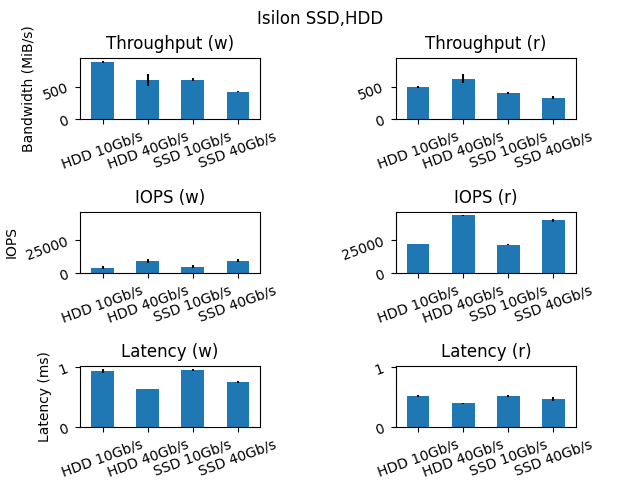

---------
Throughput write
                  mean        std
HDD 10Gb/s  878.803601  18.709457
HDD 40Gb/s  600.292803  87.651497
SSD 10Gb/s  606.877758  26.572561
SSD 40Gb/s  421.088637   9.143627
---------
Throughput read
                  mean        std
HDD 10Gb/s  492.820954  19.354635
HDD 40Gb/s  621.963134  65.783003
SSD 10Gb/s  395.877308  17.819422
SSD 40Gb/s  327.628254  22.662875
---------
IOPS write
                   mean          std
HDD 10Gb/s  4318.617123   940.576233
HDD 40Gb/s  9052.378237  1452.820299
SSD 10Gb/s  4953.676898  1122.344462
SSD 40Gb/s  9609.892948  1136.503413
---------
IOPS read
                    mean          std
HDD 10Gb/s  22353.215900   187.161457
HDD 40Gb/s  43927.077824   693.896096
SSD 10Gb/s  21739.072803   154.185243
SSD 40Gb/s  40184.774059  1188.841197
---------
Latency write
                mean       std
HDD 10Gb/s  0.936706  0.027597
HDD 40Gb/s  0.636252  0.005675
SSD 10Gb/s  0.958689  0.016840
SSD 40Gb/s  0.745047  0.017858
---------
La

In [38]:
%matplotlib notebook

## Params
result_file_prefix = "2022-06-08T19:53:53_benchmark"

## Plot code
hdd_s = load_json(f"./results/{result_file_prefix}_isilon_hdd.json")
hdd_f = load_json(f"./results/{result_file_prefix}_isilon_hdd_fast.json")
ssd_s = load_json(f"./results/{result_file_prefix}_isilon_ssd.json")
ssd_f = load_json(f"./results/{result_file_prefix}_isilon_ssd_fast.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_MiB"),
    ("throughput_read", "read_bw_mean_in_MiB"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

dfs = []
for label, metric in benchmarks:
    dfs.append(pd.concat([
        extract_results(hdd_s, metric, [label]).rename(index={label: "HDD 10Gb/s"}),
        extract_results(hdd_f, metric, [label]).rename(index={label: "HDD 40Gb/s"}),
        extract_results(ssd_s, metric, [label]).rename(index={label: "SSD 10Gb/s"}),
        extract_results(ssd_f, metric, [label]).rename(index={label: "SSD 40Gb/s"}),
    ]))

    
fig, axis = plt.subplots(3, 2)
fig.suptitle('Isilon SSD,HDD')
plt.subplots_adjust(wspace=0.7500, hspace=1.5)
    
dfs[0]["mean"].plot(
    ax=axis[0][0],
    kind='bar', rot=0,
    ylabel='Bandwidth (MiB/s)',
    title='Throughput (w)',
    yerr=dfs[0]["std"],
)
dfs[1]["mean"].plot(
    ax=axis[0][1],
    kind='bar', rot=0,
    title='Throughput (r)',
    yerr=dfs[1]["std"],
)

dfs[2]["mean"].plot(
    ax=axis[1][0],
    kind='bar', rot=0,
    ylabel='IOPS',
    title='IOPS (w)',
    yerr=dfs[2]["std"]
)

dfs[3]["mean"].plot(
    ax=axis[1][1],
    kind='bar', rot=0,
    title='IOPS (r)',
    yerr=dfs[3]["std"],
)
dfs[4]["mean"].plot(
    ax=axis[2][0],
    kind='bar', rot=0,
    ylabel='Latency (ms)',
    title='Latency (w)',
    yerr=dfs[4]["std"]
)
dfs[5]["mean"].plot(
    ax=axis[2][1],
    kind='bar', rot=0,
    title='Latency (r)',
    yerr=dfs[5]["std"],
)

axis[0][1].sharey(axis[0][0])
axis[1][0].sharey(axis[1][1])
axis[2][1].sharey(axis[2][0])
for i,j in [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]:
    axis[i][j].tick_params(labelrotation=20)
    # axis[i][j].get_legend().remove()
    
#plt.tight_layout()
# plt.savefig("paramstudy_throughput.png",bbox_inches='tight')
plt.show()

print("---------", "Throughput write", sep="\n")
print(dfs[0])
print("---------", "Throughput read", sep="\n")
print(dfs[1])
print("---------", "IOPS write", sep="\n")
print(dfs[2])
print("---------", "IOPS read", sep="\n")
print(dfs[3])
print("---------", "Latency write", sep="\n")
print(dfs[4])
print("---------", "Latency read", sep="\n")
print(dfs[5])



# Experiment: Galaxy

['1000x1K', '100x1K', '10x1K', '1x0', '1x1G', '1x1K', '1x1M', '2000x1K']
dict_keys(['irods_on_s3', 'irods_via_davrods_on_s3', 'isilon', 'irods_via_davrods_on_isilon', 'irods_on_isilon', 'netapp', 's3', 'ssd_tank'])


<IPython.core.display.Javascript object>


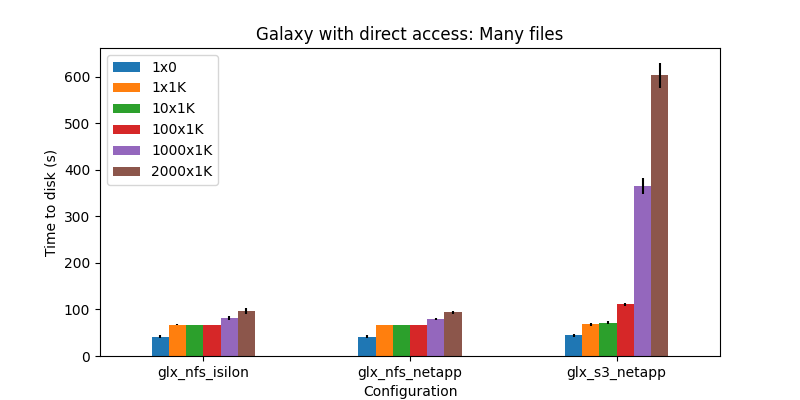

<IPython.core.display.Javascript object>


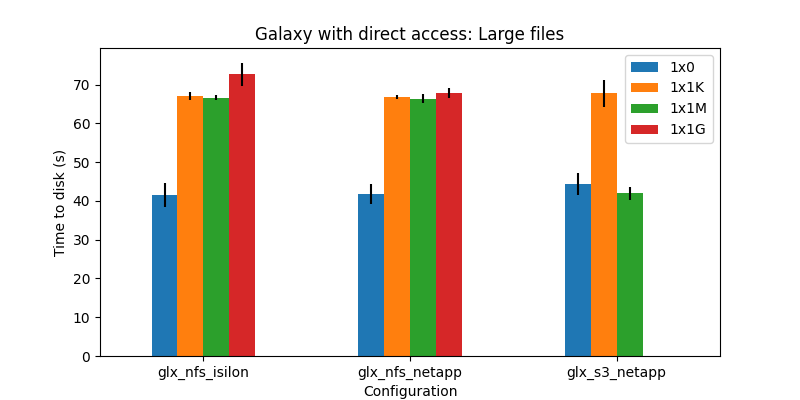

<IPython.core.display.Javascript object>


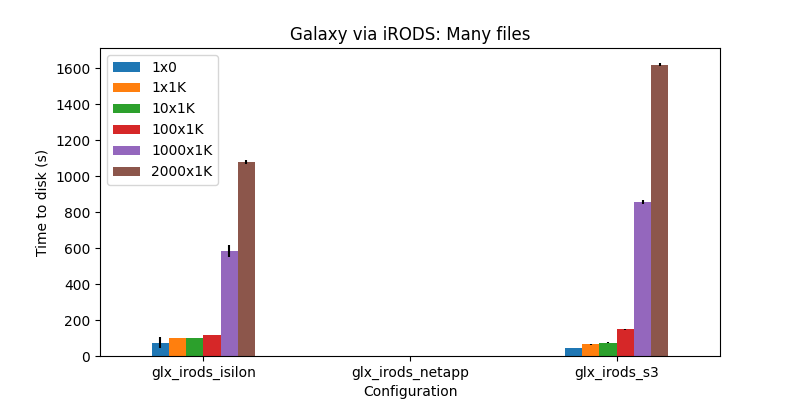

<IPython.core.display.Javascript object>


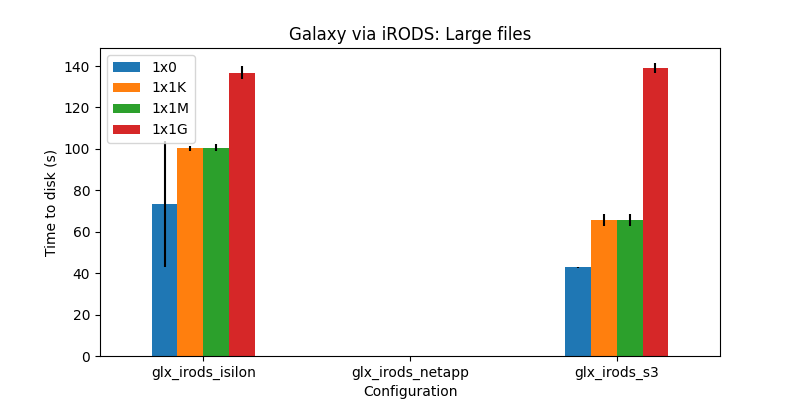

<IPython.core.display.Javascript object>


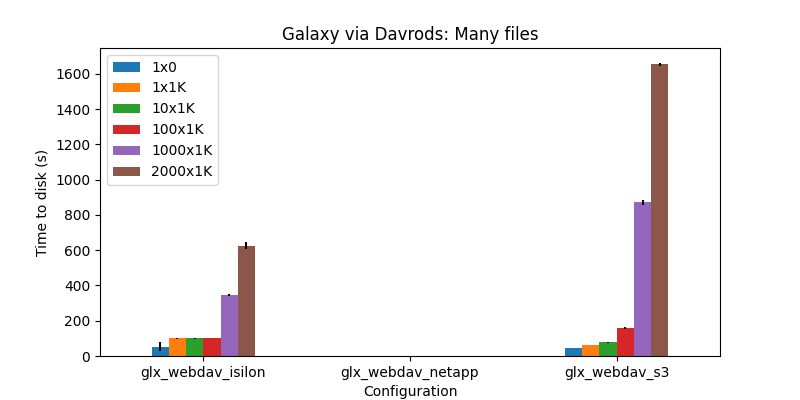

<IPython.core.display.Javascript object>


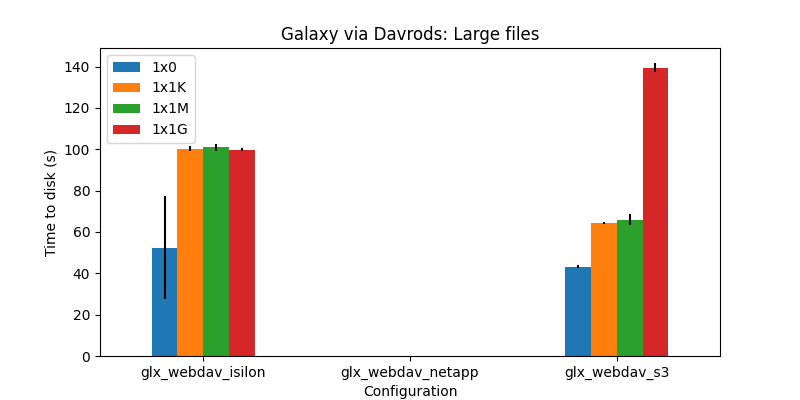

<IPython.core.display.Javascript object>


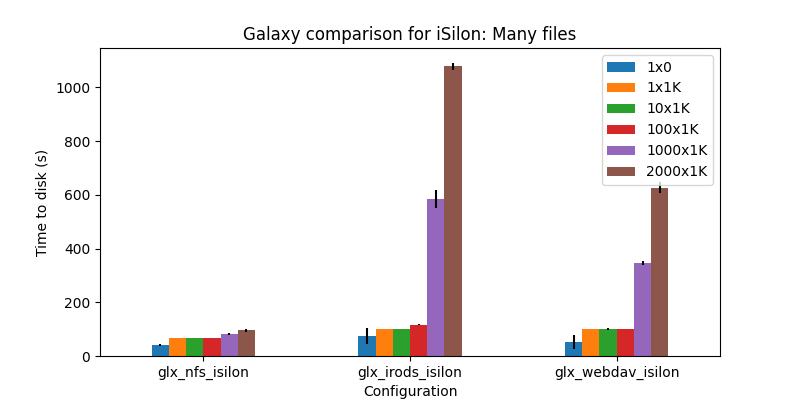

<IPython.core.display.Javascript object>


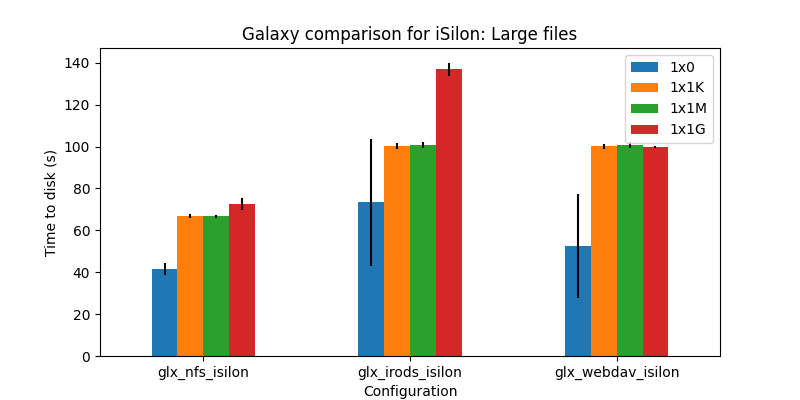

In [86]:
%matplotlib notebook

# Read in results
## Params
folder = Path("./results/galaxy")

## Plot code
res = {}


def _load():
    # res: dict[benchmark, results]
    # results: dict[target, list[total_runtime_in_s]]
    for file in folder.iterdir():
        date_str, _, _, benchmark, *target, _ = file.stem.split("_")
        target = "_".join(target)
        file_content = json.loads(file.read_text())

        run_res = file_content["results"][f"benchmark_galaxy_{benchmark}_{target}_backend"]
        if len(run_res) == 0:
            print("No result for:", date_str, benchmark, target)
            continue
        value = float(run_res[0]["total_runtime_in_s"])

        if benchmark not in res:
            res[benchmark] = {}

        if target not in res[benchmark]:
            res[benchmark][target] = []
        res[benchmark][target].append(value)

    labels = sorted(k for k in res.keys())
    return labels, res

def _extract_results(data, labels):
    pd_data = []
    for label in labels:
        values = data[label] if label in data else [0]
        mean = np.mean(values)
        #conf = confidence_interval(values)
        std = np.std(values)
        pd_data.append([mean, std])


    df = pd.DataFrame(data=pd_data, index=labels, columns=["mean", "std"])
    return df

def generate_plot(res, configs, benchmarks, title):
    data = {}
    for b in benchmarks:
        data[b] = _extract_results(res[b], configs)
    df = pd.concat(data)

    def fix_df(df):
        """unstack changes the order, fix order and rename index'"""
        df = df.reindex(index=configs, columns=benchmarks)
        df.rename(index={"isilon": "glx_nfs_isilon", "netapp": "glx_nfs_netapp", "s3": "glx_s3_netapp"}, inplace=True)
        df.rename(index={"irods_on_isilon": "glx_irods_isilon", "irods_on_netapp": "glx_irods_netapp", "irods_on_s3": "glx_irods_s3"}, inplace=True)
        df.rename(index={"irods_via_davrods_on_isilon": "glx_webdav_isilon", "irods_via_davrods_on_netapp": "glx_webdav_netapp", "irods_via_davrods_on_s3": "glx_webdav_s3"}, inplace=True)
        return df

    df_mean = fix_df(df["mean"].unstack(level=0))
    df_std = fix_df(df["std"].unstack(level=0))
    df_mean.plot(
        kind='bar', rot=0,
        xlabel='Configuration',
        ylabel='Time to disk (s)',
        figsize=(8, 4),
        yerr=df_std
    )

    plt.legend()
    plt.title(title)
    plt.savefig(title.lower().replace(" ", "_").replace(":","")+".png",bbox_inches='tight')
    plt.show()

labels, res = _load()
print(labels)
print(res["1x0"].keys())
many_files = ["1x0", "1x1K", "10x1K", "100x1K", "1000x1K", "2000x1K"]
large_files = ["1x0", "1x1K", "1x1M", "1x1G", ] #"10x1G"]

generate_plot(res, ["isilon", "netapp", "s3"], many_files, "Galaxy with direct access: Many files")
generate_plot(res, ["isilon", "netapp", "s3"], large_files, "Galaxy with direct access: Large files")

generate_plot(res, ["irods_on_isilon", "irods_on_netapp", "irods_on_s3"], many_files, "Galaxy via iRODS: Many files")
generate_plot(res, ["irods_on_isilon", "irods_on_netapp", "irods_on_s3"], large_files, "Galaxy via iRODS: Large files")

generate_plot(res, ["irods_via_davrods_on_isilon", "irods_via_davrods_on_netapp", "irods_via_davrods_on_s3"], many_files, "Galaxy via Davrods: Many files")
generate_plot(res, ["irods_via_davrods_on_isilon", "irods_via_davrods_on_netapp", "irods_via_davrods_on_s3"], large_files, "Galaxy via Davrods: Large files")

generate_plot(res, ["isilon", "irods_on_isilon", "irods_via_davrods_on_isilon"], many_files, "Galaxy comparison for iSilon: Many files")
generate_plot(res, ["isilon", "irods_on_isilon", "irods_via_davrods_on_isilon"], large_files, "Galaxy comparison for iSilon: Large files")

